# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)+1

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# 定义 CTC Loss

In [2]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


# 定义网络结构

In [3]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
for i in range(3):
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, init='he_normal', name='gru1_b')(x)
gru1_merged = merge([gru_1, gru_1b], mode='sum')

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, init='he_normal', name='gru2_b')(gru1_merged)
x = merge([gru_2, gru_2b], mode='concat')
x = Dropout(0.25)(x)
x = Dense(n_class, init='he_normal', activation='softmax')(x)
base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, kernel_initializer="he_normal", name="gru1")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, go_backwards=True, kernel_initializer="he_normal", name="gru1_b", return_sequences=True)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, 

# 网络结构可视化

In [4]:
#from keras.utils.vis_utils import plot_model
#from IPython.display import Image

#plot_model(model, to_file="model.png", show_shapes=True)
#Image('model.png')

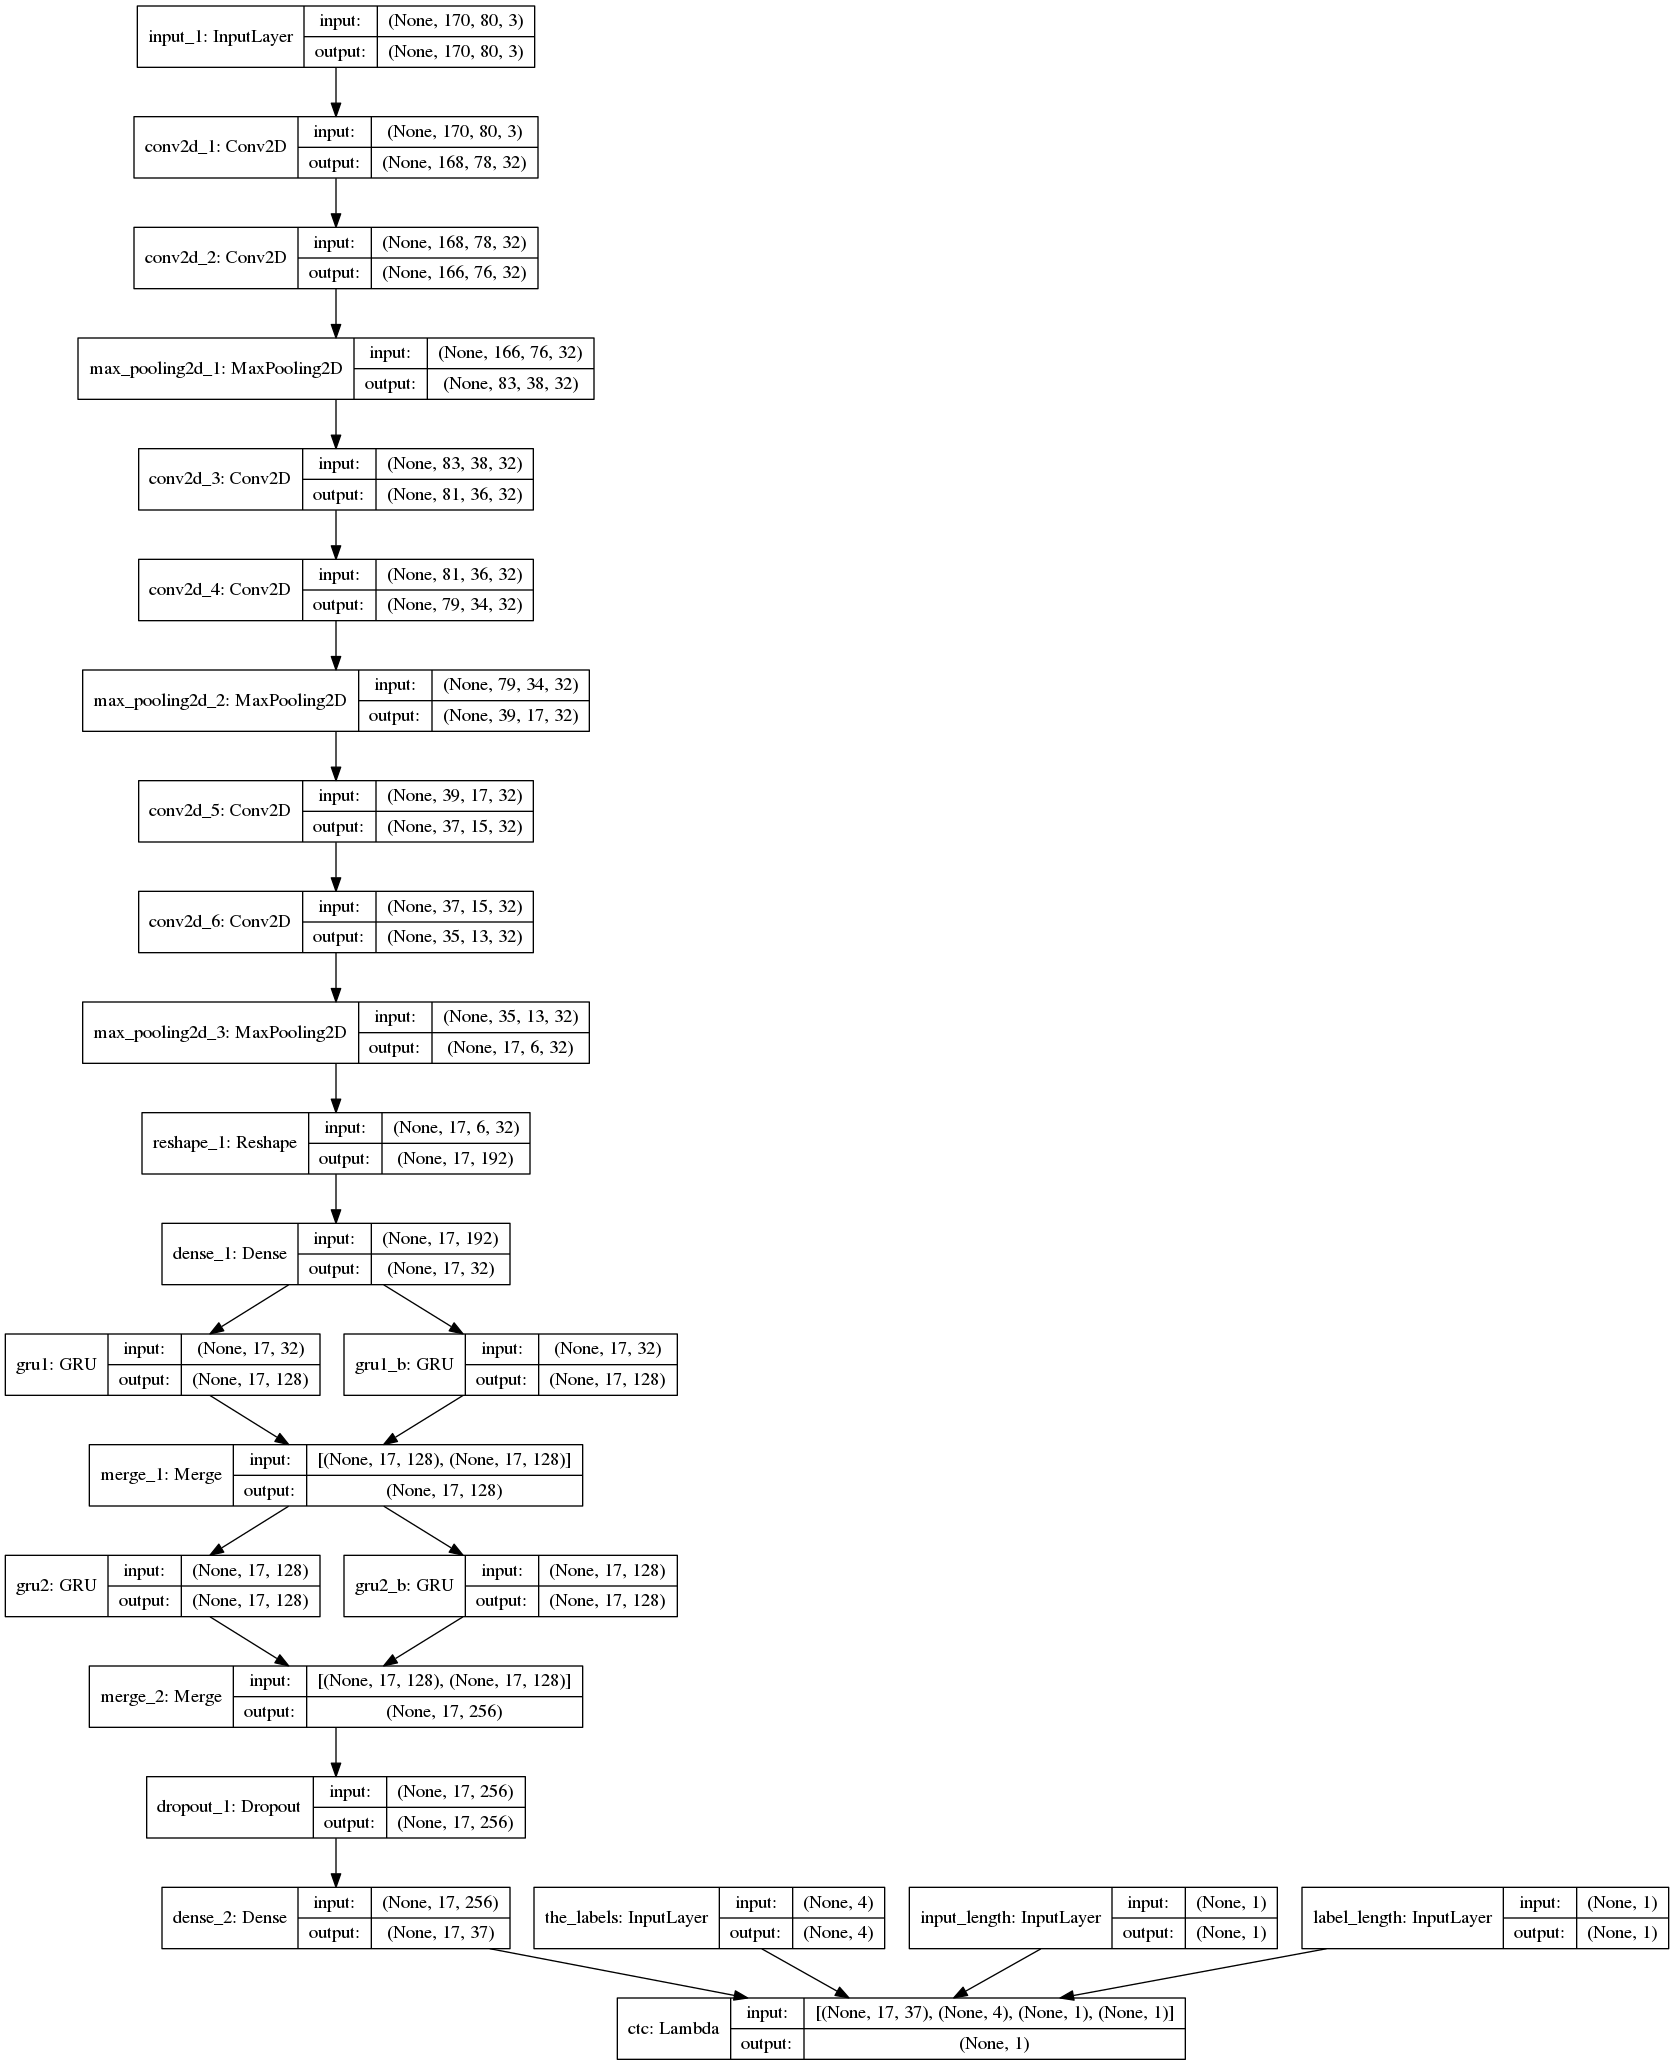

In [5]:
from IPython.display import SVG, Image
from keras.utils.vis_utils import plot_model, model_to_dot

plot_model(model, show_shapes=True)
Image('model.png')
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 导入权值

这是之前跑好了的模型

In [93]:
model.load_weights('model.h5')

# 定义数据生成器

In [94]:
def gen(batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str)).transpose(1, 0, 2)
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), np.ones(batch_size)*n_len], np.ones(batch_size)

# 测试生成器

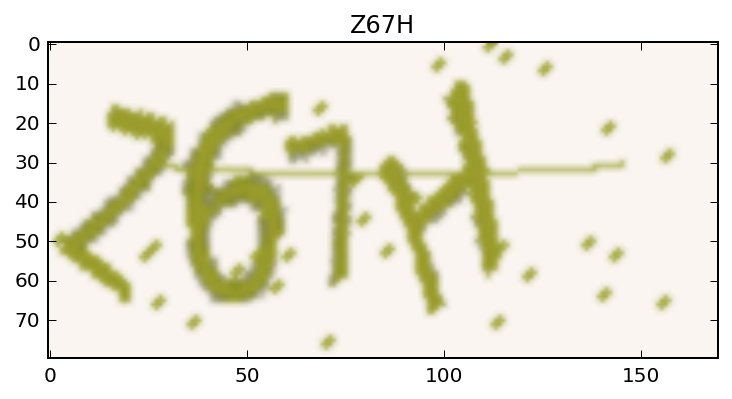

In [95]:
[X_test, y_test, _, _], _  = next(gen(1))
plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title(''.join([characters[x] for x in y_test[0]]))

In [96]:
[X_test, y_test,aa, bb], cc  = next(gen(128))

In [97]:
int(conv_shape[1]-2)

15

In [98]:
X_test.shape, y_test.shape,aa,bb,cc

((128, 170, 80, 3),
 (128, 4),
 array([ 15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
         15.,  15.,  15.,  15.,  15.,  15.,  15.]),
 array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.,  4.,  4

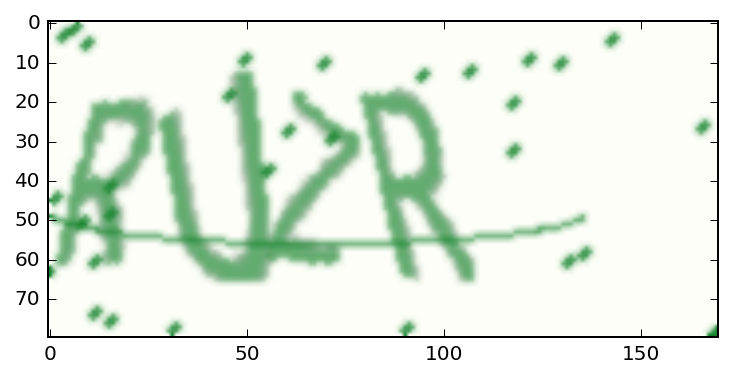

In [99]:
plt.imshow(X_test[0].transpose([1,0,2]))

# 训练模型

In [100]:
def evaluate(model, batch_num=10):
    batch_acc = 0
    generator = gen(128)
    for i in range(batch_num):
        [X_test, y_test, _, _], _  = next(generator)
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
        if out.shape[1] == 4:
            batch_acc += ((y_test == out).sum(axis=1) == 4).mean()
    return batch_acc / batch_num

In [101]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
        print
        print 'acc: %f%%'%acc

evaluator = Evaluate()

In [79]:
model.fit_generator(gen(128), samples_per_epoch=51200, nb_epoch=200,
                    callbacks=[EarlyStopping(patience=10), evaluator],
                    validation_data=gen(), nb_val_samples=1280)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=51200, epochs=200, callbacks=[<keras.ca..., validation_steps=1280)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/200
   11/51200 [..............................] - ETA: 311996s - loss: 24.3403

KeyboardInterrupt: 

In [11]:
model.fit_generator(gen(128), samples_per_epoch=51200, nb_epoch=200,
                    callbacks=[EarlyStopping(patience=10), evaluator],
                    validation_data=gen(), nb_val_samples=1280)

Epoch 1/200
51072/51200 [============================>.] - ETA: 0s - loss: 0.2491
acc: 95.000000%
51200/51200 [==============================] - 141s - loss: 0.2488 - val_loss: 0.1209
Epoch 2/200
51072/51200 [============================>.] - ETA: 0s - loss: 0.2485
acc: 94.531250%
51200/51200 [==============================] - 137s - loss: 0.2492 - val_loss: 0.1879
Epoch 3/200
51072/51200 [============================>.] - ETA: 0s - loss: 0.2293
acc: 95.468750%
51200/51200 [==============================] - 135s - loss: 0.2291 - val_loss: 0.1573
Epoch 4/200
51072/51200 [============================>.] - ETA: 0s - loss: 0.2408
acc: 94.765625%
51200/51200 [==============================] - 134s - loss: 0.2404 - val_loss: 0.1587
Epoch 5/200
51072/51200 [============================>.] - ETA: 0s - loss: 0.2289
acc: 95.937500%
51200/51200 [==============================] - 135s - loss: 0.2287 - val_loss: 0.1539
Epoch 6/200
51072/51200 [============================>.] - ETA: 0s - loss: 0.235

In [ ]:
model.save('model.h5')

# 测试模型

[(26, 'Q'),
 (14, 'E'),
 (36, ' '),
 (10, 'A'),
 (32, 'W'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' ')]

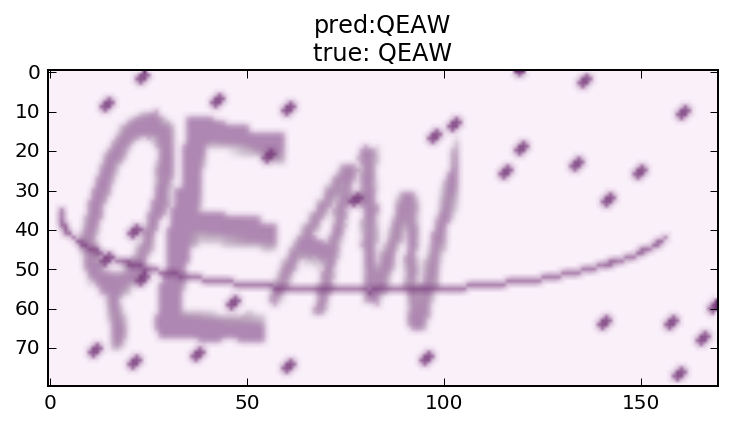

In [130]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
y_pred = y_pred[:,2:,:]
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))

In [131]:
len(characters2),y_test

(37, array([[26, 14, 10, 32]], dtype=uint8))

In [132]:
[X_test, y_test,aa, bb], cc  = next(gen(1))
X_test.shape, y_test.shape,aa,bb,cc

((1, 170, 80, 3), (1, 4), array([ 15.]), array([ 4.]), array([ 1.]))

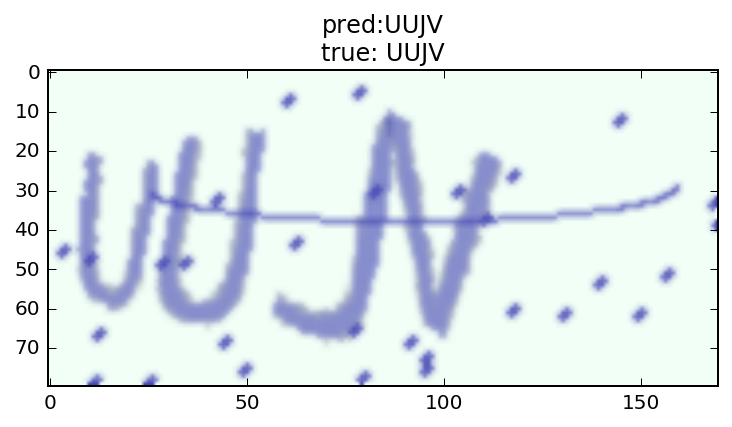

In [143]:
plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

In [133]:
y_pred = base_model.predict(X_test)
y_pred.shape

(1, 17, 37)

In [134]:
y_pred = y_pred[:,2:,:]
y_pred.shape

(1, 15, 37)

In [135]:
K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])

array([[30, 30, 19, 31]])

In [140]:
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out

array([[30, 30, 19, 31]])

In [141]:
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])
out, y_true

('UUJV', 'UUJV')

In [146]:
argmax = np.argmax(y_pred, axis=2)[0]
argmax

array([30, 36, 30, 19, 31, 31, 36, 36, 36, 36, 36, 36, 36, 36, 36])

In [147]:
list(zip(argmax, ''.join([characters2[x] for x in argmax])))

[(30, 'U'),
 (36, ' '),
 (30, 'U'),
 (19, 'J'),
 (31, 'V'),
 (31, 'V'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' ')]

# 计算模型总体准确率

In [19]:
evaluate(base_model)

0.74531250000000004

In [16]:
model.save('model.h5')

In [155]:
import cv2

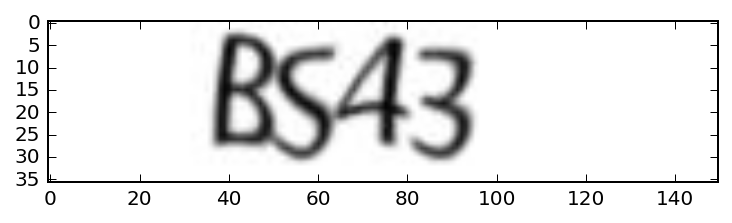

In [270]:
img=cv2.imread('/home/zx/桌面/代码/OCR_SUM/codes/图片验证码识别/bs43.jpg')
plt.imshow(img)

In [271]:
img.shape

(36, 150, 3)

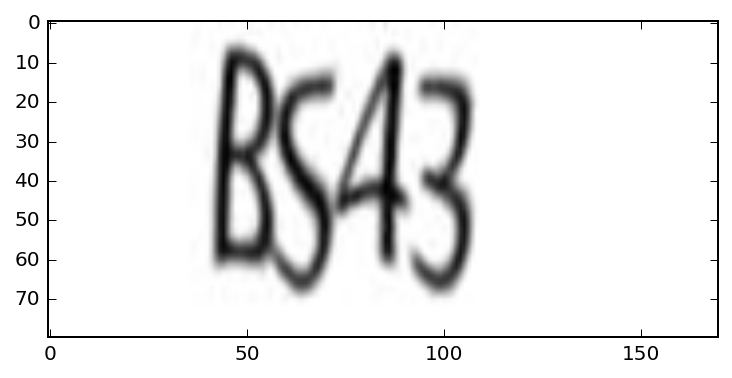

In [272]:
img2=cv2.resize(img,(170, 80),interpolation=cv2.INTER_CUBIC)
plt.imshow(img2)

In [273]:
img2.shape

(80, 170, 3)

In [274]:
img2=img2.transpose(1, 0, 2)
img2.shape

(170, 80, 3)

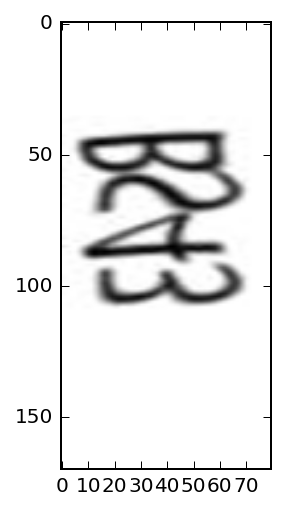

In [275]:
plt.imshow(img2)

In [276]:
img2=np.array([img2])
img2.shape

(1, 170, 80, 3)

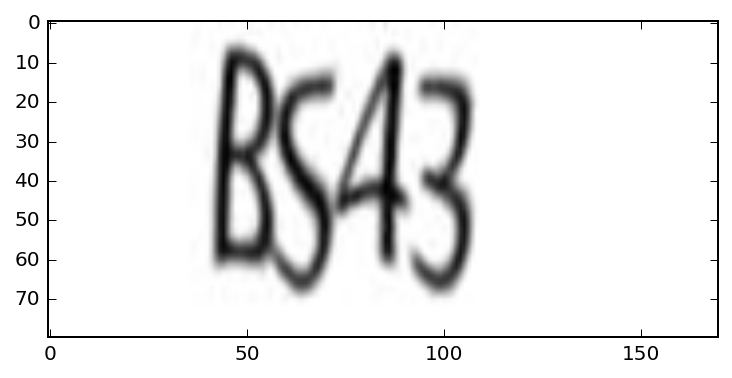

In [277]:
plt.imshow(img2[0].transpose(1, 0, 2))

[(1, '1'),
 (16, 'G'),
 (36, ' '),
 (16, 'G'),
 (11, 'B'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' ')]

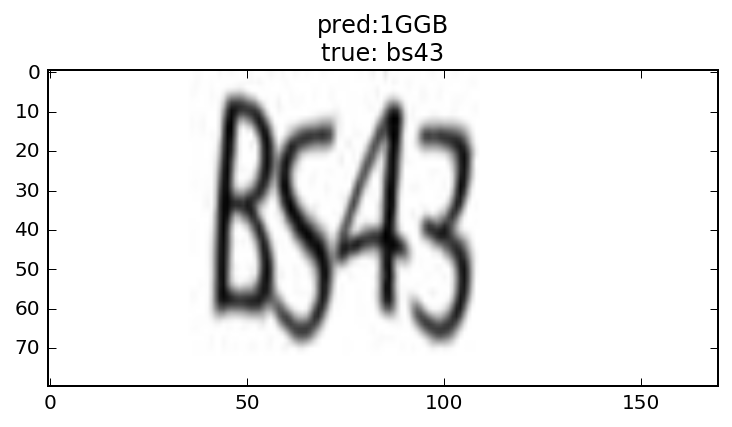

In [286]:
characters2 = characters + ' '
#[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(img2)
y_pred = y_pred[:,2:,:]
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :5]
out = ''.join([characters[x] for x in out[0]])


plt.imshow(img2[0].transpose(1, 0, 2))
plt.title('pred:' + str(out) + '\ntrue: ' + 'bs43')

argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))